In [1]:
%matplotlib notebook
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import errno

###############################  To get reproducible results  ########################################
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";  # The GPU id to use, usually either "0" or "1";
os.environ["CUDA_VISIBLE_DEVICES"]="1";  # Do other imports now...


# Seed value
# Apparently you may use different seed values at each stage
seed_value= 0

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.set_random_seed(seed_value)


# 5. Configure a new global `tensorflow` session
from keras import backend as K

"""
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)
"""

from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.Session(config=config)
set_session(sess)  # set this TensorFlow session as the default session for Keras


#######################################################################################################



import pandas as pd

from keras.layers import Layer
from keras.layers import Dense, Dropout, Input, Activation
from keras.layers import Conv2D, Flatten, Lambda, MaxPooling2D
from keras.layers import Reshape, Conv2DTranspose
from keras.layers.merge import concatenate
from keras.models import Model, Sequential
from keras.datasets import fashion_mnist as in_dist_dataset
from keras.datasets import mnist as out_dist_dataset
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras.callbacks import EarlyStopping, TensorBoard
from keras.utils import np_utils
from keras.models import load_model

import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import argparse
import os

import tensorflow as tf
from keras.optimizers import RMSprop, SGD, Adam, Adadelta

from keras.constraints import Constraint, NonNeg
from keras.constraints import Constraint

from keras.callbacks import EarlyStopping
from keras.initializers import Ones, Constant

from keras import regularizers

from sympy import Matrix


from sklearn.mixture import GaussianMixture
import pickle

import h5py

from sklearn import metrics

tf.estimator package not installed.
tf.estimator package not installed.


Using TensorFlow backend.


In [2]:
in_dist = "fmnist"
out_dist = "mnist"
number_of_classes = 6
in_class_min = 0
in_class_max = 4
latent_dim = 10

In [3]:
# n = number of points per class - 2 class data
def generate_nd_sphere_data(r, dims, n):
    # number of points
    X = np.zeros((n, dims))
    for i in range(dims):
        X[:, i] = np.random.normal(0, 1, n)

    D = np.sqrt(np.sum(np.square(X), axis=-1))

    X = X*1.0*r[:, np.newaxis]/D[:, None]
    y = np.ones((n, 1)) * (number_of_classes-1)

    #Y = np_utils.to_categorical(Y, 3)


    return X, y

In [4]:
def generate_nd_hyperellipsoid_data(m, Cov, r, dims, n):
    # generate for randorm radii between r and r+0.5r
    rs = np.random.uniform(r, r+0.5*r, n)
    X, y = generate_nd_sphere_data(rs, dims, n)
    #print(np.max(X))
    #Cov_inv = np.linalg.pinv(Cov)
    Cov_inv = Cov
    C = np.zeros_like(Cov)
    
    for i in range(C.shape[0]):
        for j in range(i+1):
            s1 = 0
            for k in range(j):
                s1 += C[i,j]*C[j,k]
            s2 = 0
            for k in  range(j):
                s2 += C[j,k]*C[j,k]
            C[i,j] = (Cov[i,j] - s1)/np.sqrt(np.abs(Cov[j,j] - s2))
    
    for i in range(X.shape[0]):
        X[i, :] = np.dot(C, X[i, :]) + m
    
    return X, y

In [5]:
def auroc(in_dist, out_dist):
    #calculate the AUROC

    Y1 = out_dist
    X1 = in_dist
    end = np.max([np.max(X1), np.max(Y1)])
    start = np.min([np.min(X1),np.min(Y1)])
    gap = (end- start)/200000

    aurocBase = 0.0
    fprTemp = 1.0
    for delta in np.arange(start, end, gap):
        tpr = np.sum(np.sum(X1 >= delta)) / np.float(len(X1))
        fpr = np.sum(np.sum(Y1 > delta)) / np.float(len(Y1))
        #f1.write("{}\n".format(tpr))
        #f2.write("{}\n".format(fpr))
        aurocBase += (-fpr+fprTemp)*tpr
        fprTemp = fpr

    return aurocBase

In [6]:
def sklearn_auroc(p_in, p_out):
    y = list(np.ones(p_in.shape[0]))
    y.extend(np.zeros(p_out.shape[0]))
    pred = list(np.concatenate((p_in, p_out),axis=0))

    fpr, tpr, thresholds = metrics.roc_curve(y, pred, pos_label=1)
    
    # for fpr95
    idx_95 = (np.abs(tpr - 0.95)).argmin()
    idx_80 = (np.abs(tpr - 0.80)).argmin()
    return metrics.auc(fpr, tpr), fpr[idx_95], fpr[idx_80]

In [7]:
# reparameterization trick
# instead of sampling from Q(z|X), sample eps = N(0,I)
# then z = z_mean + sqrt(var)*eps
def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.

    # Arguments
        args (tensor): mean and log of variance of Q(z|X)

    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    # return z_mean + K.exp(0.5 * z_log_var) * epsilon
    return z_mean


In [8]:
def plot_results(models,
                 data,
                 batch_size=128,
                 model_name="vae_"+in_dist):
    """Plots labels and MNIST digits as function of 2-dim latent vector

    # Arguments
        models (tuple): encoder and decoder models
        data (tuple): test data and label
        batch_size (int): prediction batch size
        model_name (string): which model is using this function
    """

    encoder, decoder = models
    x_test, Y_test = data

    
    try:
        os.makedirs(model_name)
    except OSError as e:
        pass

    #os.makedirs(model_name, exist_ok=True)

    z_mean, _, _ = encoder.predict([x_test, Y_test],
                                   batch_size=batch_size)


    if z_mean.shape[1]==2:
        filename = os.path.join(model_name, "vae_mean.png")
        # display a 2D plot of the digit classes in the latent space
        plt.figure(figsize=(12, 10))
        plt.scatter(z_mean[:, 0], z_mean[:, 1], c=np.argmax(Y_test, axis=-1))
        plt.colorbar()
        plt.xlabel("z[0]")
        plt.ylabel("z[1]")
        plt.savefig(filename)
        plt.show()

    z = np.hstack((z_mean, Y_test))
    n=30
    digit_size = 28
    x_decoded = decoder.predict(z)
    print(x_decoded.shape)

    filename = os.path.join(model_name, "reconstructed_digits.png")

    figure = np.zeros((digit_size * n, digit_size * n))


    count = 0
    for i in range(n):
        for j in range(n):
            digit = x_decoded[count].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit
            count += 1

    plt.figure(figsize=(10, 10))
    plt.imshow(figure, cmap='Greys_r')
    plt.savefig(filename)
    plt.show()

In [9]:
class Vae:
    def __init__(self, load_weights):
        
        # MNIST dataset
        (self.x_train, self.y_train), (self.x_test, self.y_test) = in_dist_dataset.load_data()


        ind_train = np.where((self.y_train >= in_class_min) & (self.y_train <= in_class_max))[0]
        ind_test = np.where((self.y_test >= in_class_min) & (self.y_test <= in_class_max))[0]

        self.Y_train = np_utils.to_categorical(self.y_train[ind_train,], number_of_classes-1)
        self.Y_test = np_utils.to_categorical(self.y_test[ind_test], number_of_classes-1)

        image_size = self.x_train.shape[1]
        self.x_train = np.reshape(self.x_train, [-1, image_size, image_size, 1])
        self.x_test = np.reshape(self.x_test, [-1, image_size, image_size, 1])
        self.x_train = self.x_train.astype('float32') / 255
        self.x_test = self.x_test.astype('float32') / 255

        # network parameters
        input_shape = (image_size, image_size, 1)
        self.batch_size = 128
        kernel_size = 3
        filters = 16
        self.latent_dim = latent_dim
        epochs = 100

        # VAE model = encoder + decoder
        # build encoder model
        inputs = Input(shape=input_shape, name='encoder_input')
        cond_inputs = Input(shape=(number_of_classes-1, ))
        x = inputs
        for i in range(2):
            filters *= 2
            x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               activation='relu',
               strides=2,
               padding='same')(x)

        # shape info needed to build decoder model
        shape = K.int_shape(x)
    
        # generate latent vector Q(z|X)
        x = Flatten()(x)
        x = concatenate([x, cond_inputs])
        x = Dense(16, activation='relu')(x)
        z_mean = Dense(self.latent_dim, name='z_mean')(x)
        z_log_var = Dense(self.latent_dim, name='z_log_var')(x)

        # use reparameterization trick to push the sampling out as input
        # note that "output_shape" isn't necessary with the TensorFlow backend
        z = Lambda(sampling, output_shape=(self.latent_dim,), name='z')([z_mean, z_log_var])

        # instantiate encoder model
        self.encoder = Model([inputs, cond_inputs], [z_mean, z_log_var, z], name='encoder')
        self.encoder.summary()
        #plot_model(self.encoder, to_file='vae_encoder.png', show_shapes=True)

        z_cond = concatenate([z, cond_inputs])

        # build decoder model
        latent_inputs = Input(shape=(self.latent_dim+(number_of_classes-1),), name='z_sampling')
        
        x = Dense(16, activation='relu')(latent_inputs)
        x = Dense(shape[1] * shape[2] * shape[3], activation='relu')(latent_inputs)
        x = Reshape((shape[1], shape[2], shape[3]))(x)

        filters_new = filters
        for i in range(2):
            x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        activation='relu',
                        strides=2,
                        padding='same')(x)
            filters //= 2

        outputs = Conv2DTranspose(filters=1,
                          kernel_size=kernel_size,
                          activation='sigmoid',
                          padding='same',
                          name='decoder_output')(x)

        # instantiate decoder model
        self.decoder = Model(latent_inputs, outputs, name='decoder')
        self.decoder.summary()
        #plot_model(self.decoder, to_file='vae_decoder.png', show_shapes=True)

        # decoder_new
        latent_inputs_new = Input(shape=(self.latent_dim+(number_of_classes-1),), name='z_sampling')
        x = Dense(shape[1] * shape[2] * shape[3], activation='relu')(latent_inputs_new)
        x = Reshape((shape[1], shape[2], shape[3]))(x)

        for i in range(2):
            x = Conv2DTranspose(filters=filters_new,
                        kernel_size=kernel_size,
                        activation='relu',
                        strides=2,
                        padding='same')(x)
            filters_new //= 2

        x = Conv2DTranspose(filters=1,
                          kernel_size=kernel_size,
                          activation='sigmoid',
                          padding='same',
                          name='decoder_output')(x)

        outputs_new = Flatten()(x)

        # instantiate decoder model
        self.decoder_new = Model(latent_inputs_new, outputs_new, name='decoder')
        self.decoder_new.summary()

        # instantiate VAE model
        outputs = self.decoder(z_cond)
        vae = Model([inputs, cond_inputs], outputs, name='vae')

        
        models = (self.encoder, self.decoder)

        # VAE loss = mse_loss or xent_loss + kl_loss
        #reconstruction_loss = mse(K.flatten(inputs), K.flatten(outputs))
        reconstruction_loss = binary_crossentropy(K.flatten(inputs),
                                                  K.flatten(outputs))

        reconstruction_loss *= image_size * image_size
        kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
        kl_loss = K.sum(kl_loss, axis=-1)
        kl_loss *= -0.5
        vae_loss = K.mean(reconstruction_loss + kl_loss)
        vae.add_loss(vae_loss)
        #vae.add_loss(reconstruction_loss)
        vae.compile(optimizer='rmsprop')
        vae.summary()
        #plot_model(vae, to_file='vae.png', show_shapes=True)

        ind_train = np.where((self.y_train >= in_class_min) & (self.y_train <= in_class_max))[0]
        ind_test = np.where((self.y_test >= in_class_min) & (self.y_test <= in_class_max))[0]

        data = (self.x_test[ind_test,], self.Y_test)
        print("x_test shape is: ", self.x_test[ind_test,].shape)
        if(load_weights):
            print("loading weights for vae")
            vae.load_weights('vae_'+in_dist+'.h5')
            print("finished loading weights f")
            # train the autoencoder
        else:
            vae.fit([self.x_train[ind_train,], self.Y_train],
                epochs=epochs,
                batch_size=self.batch_size,
                validation_data=([self.x_test[ind_test,], self.Y_test], None),
                callbacks = [EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)])
            vae.save_weights('vae_'+in_dist+'.h5')
        self.set_decoder_new_weights()
        plot_results(models, data, batch_size=self.batch_size, model_name="vae")

    def set_decoder_new_weights(self):
        print("setting new decoder weights")
        for i, layer in enumerate(self.decoder.layers):
            print("i is: ", i)
            self.decoder_new.layers[i].set_weights(layer.get_weights())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 14, 14, 32)   320         encoder_input[0][0]              
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 7, 7, 64)     18496       conv2d_1[0][0]                   
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 3136)         0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
input_1 (I

finished loading weights f
setting new decoder weights
i is:  0
i is:  1
i is:  2
i is:  3
i is:  4
i is:  5
(5000, 28, 28, 1)


<IPython.core.display.Javascript object>


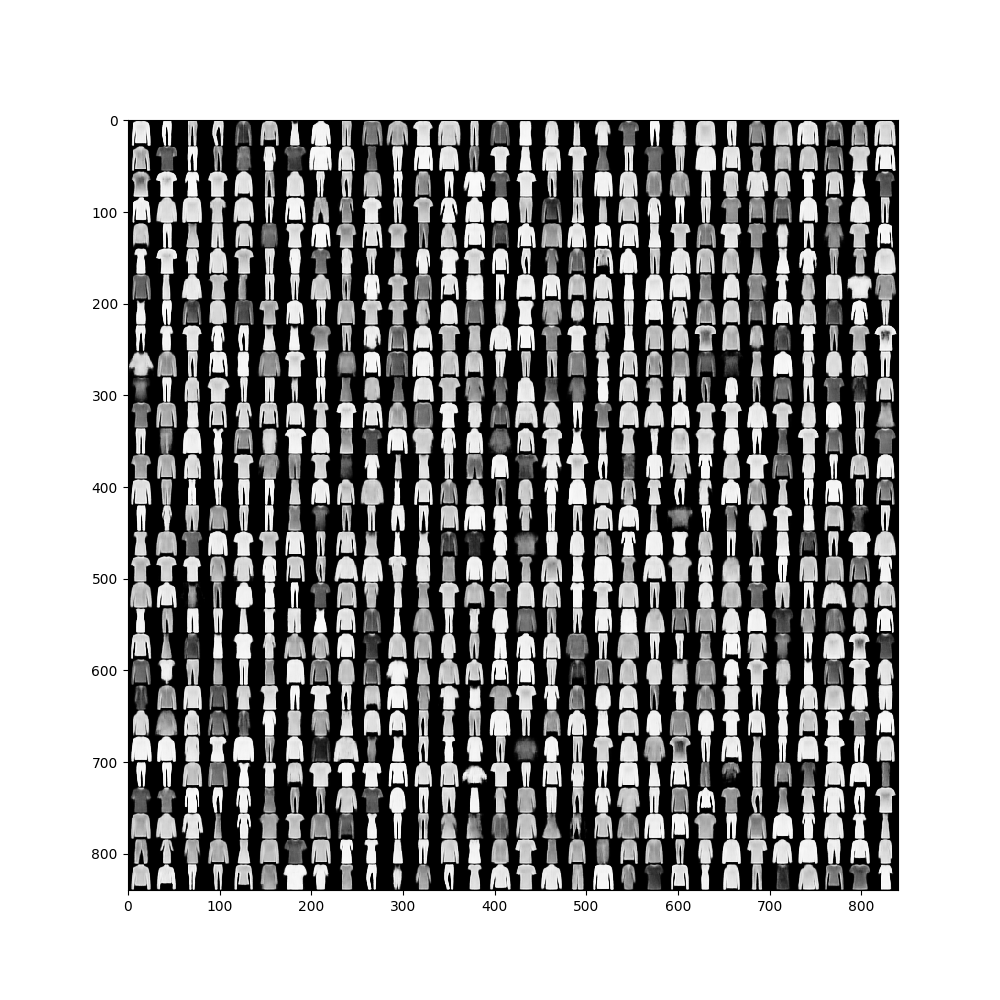

In [10]:
vae = Vae(load_weights=True)

In [ ]:
def get_jacobian_functions(model, classes=None):

        if model==None:
            print("The model is none.")
            return None
    
        if classes==None:
            classes=range(784)
        #--------------------------------    
        gradients = {}
        for c in classes:
            grads = K.gradients(model.output[:,c], model.layers[0].input)[0]
            gradients[c]= K.function([model.layers[0].input], [grads])              
        #--------------------------------
        return gradients

# output is np.array of shape (inputs.shape[0], input_dim, latent_dim)
def get_jacobian(inputs, encoder, decoder):
        J_fn = get_jacobian_functions(decoder)

        z_mean, _, _ = encoder.predict(inputs)
        J = np.empty((z_mean.shape[0], 784, z_mean.shape[1]))

        z = np.hstack((z_mean, inputs[1]))

        # do it batch_wise
        n = z_mean.shape[0]
        batch_size = min(n, 10000)
        start = 0
        end = batch_size
        while(start<n):
            for i in range(len(J_fn)):
                J[start:end, i, :] = J_fn[i]([z[start:end]])[0][:, 0:z_mean.shape[1]]
                print(i)
            start = start+batch_size
            end = min(end+batch_size, n)

        return J

    
ind_train = np.where((vae.y_train >= in_class_min) & (vae.y_train <= in_class_max))[0]
ind_test = np.where((vae.y_test >= in_class_min) & (vae.y_test <= in_class_max))[0]

Y_train = np_utils.to_categorical(vae.y_train[ind_train, ])
Y_test = np_utils.to_categorical(vae.y_test[ind_test, ])

print("Calculating Jacobians")
J_train = get_jacobian([vae.x_train[ind_train,], Y_train], vae.encoder, vae.decoder_new)
print("J_train done!")
J_test = get_jacobian([vae.x_test[ind_test,], Y_test], vae.encoder, vae.decoder_new)
print("J_test done!")
np.save('J_train_'+in_dist+'.npy', J_train)
np.save('J_test_'+in_dist+'.npy', J_test)

print("Jacobians calculated")

In [11]:
# Classifier

# Build a classifier with outlier samples only from the boundary.
import keras

class Classifier:

    # 3 Class classifier - class 2 represents outliers and class 0,1 represent inliers.
    # Class 0 sampled from a circle centered at (x, y) = (-2, 0) with radius 0.5
    # Class 1 sampled from a circle centered at (x, y) = (+2, 0) with radius 0.5
    # Class 2 sampled from rectagle with origin (x, y) = (-3, -1) with h=2, w=6 excluding regions covered by inliers.

    # Generate n points uniformly within a circle of radius r, centered at (x, y)
    # return as a numpy array n x 2 of dtype = float32
    def __init__(self, vae, is_load_J=False, is_load_test_ood=False):
        self.number_of_classes = number_of_classes
        self.input_shape = (28, 28, 1)
        self.input_dim = 28*28
        self.epochs = 200
        self.batch_size = 128
        self.init_lr = 0.1
        #self.decay = 0.001
        self.class_weight = self.set_class_weight(ood_class_weight=0.1)
        #self.class_weight_decay = 0.001
        self.model = self.get_model()

        self.nullspaces = h5py.File('/data/full_fmnist_0_4_cond_latent_dim_10/nullspaces_'+in_dist+'.hdf5', 'r')

        self.maha_info = self.get_mahalanobis_info(vae.encoder)

        self.X_train, self.Y_train, self.X_test, self.Y_test, self.X_test_in_dist, self.Y_test_in_dist, self.X_test_ood_in_dist, self.Y_test_ood_in_dist, self.X_test_ood_out_dist, self.Y_test_ood_out_dist, self.X_test_notMNIST, self.X_test_eMNIST = self.get_data(vae, is_load_J, is_load_test_ood)

        self.x_ood_sphere, self.Y_ood_sphere = generate_nd_sphere_data(np.ones(2000)*self.get_sphere_radius(vae.x_train)+2, self.input_dim, 2000)
        self.x_ood_sphere = np.reshape(self.x_ood_sphere, [-1, self.input_shape[0], self.input_shape[1], self.input_shape[2]])
        self.Y_ood_sphere = np_utils.to_categorical(self.Y_ood_sphere, self.number_of_classes)
        self.inds_temp = None

    def set_class_weight(self, ood_class_weight=0.5):
        class_weight = {}
        for i in range(self.number_of_classes-1):
            class_weight[i] = 1.0
        class_weight[self.number_of_classes-1] = ood_class_weight
        return class_weight


    def get_sphere_radius(self, x):
        return np.max(np.sqrt(np.sum(np.square(x), axis=(1, 2, 3))))


    def calculate_auroc(self):

        inds_out = np.where(self.Y_test[:, self.number_of_classes-1] == 1)[0]
        inds_in = np.array(range(self.Y_test.shape[0]))
        inds_in = np.delete(inds_in, inds_out, axis=0)


    
        p_out = 1.0 - self.model.predict(self.X_test[inds_out])[:,-1]
        p_in = 1.0 - self.model.predict(self.X_test[inds_in])[:,-1]
        p_ood_in_dist = 1 - self.model.predict(self.X_test_ood_in_dist)[:,-1]
        p_ood_out_dist = 1 - self.model.predict(self.X_test_ood_out_dist)[:,-1]
        p_ood_sphere = 1 - self.model.predict_proba(self.x_ood_sphere)[:,-1]
        p_ood_notMNIST = 1 - self.model.predict_proba(self.X_test_notMNIST)[:,-1]
        p_ood_eMNIST = 1 - self.model.predict_proba(self.X_test_eMNIST)[:,-1]


        print("With prediction prob of n+1^th class")
        print("SKLERAN AUROC and fpr_95 for generated_ood is: ", sklearn_auroc(p_in, p_out))
        print("SKLEARN AUROC and fpr_95 for %s_ood is: " % in_dist, sklearn_auroc(p_in, p_ood_in_dist))
        print("SKLEARN AUROC and fpr_95 for %s_ood is: " % out_dist, sklearn_auroc(p_in, p_ood_out_dist))
        print("SKLEARN AUROC and fpr_95 for sphere_ood is: ", sklearn_auroc(p_in, p_ood_sphere))
        print("SKLEARN AUROC and fpr_95 for notMNIST is: ", sklearn_auroc(p_in, p_ood_notMNIST))
        print("SKLEARN AUROC and fpr_95 for eMnist is: ", sklearn_auroc(p_in, p_ood_eMNIST))

        p_out = np.max(self.model.predict(self.X_test[inds_out])[:,0:-1], axis=-1)
        p_in = np.max(self.model.predict(self.X_test[inds_in])[:,0:-1], axis=-1)
        p_ood_in_dist = np.max(self.model.predict(self.X_test_ood_in_dist)[:,0:-1], axis=-1)
        p_ood_out_dist = np.max(self.model.predict(self.X_test_ood_out_dist)[:,0:-1], axis=-1)
        p_ood_sphere = np.max(self.model.predict(self.x_ood_sphere)[:,0:-1], axis=-1)
        p_ood_notMNIST = np.max(self.model.predict(self.X_test_notMNIST)[:,0:-1], axis=-1)
        p_ood_eMNIST = np.max(self.model.predict(self.X_test_eMNIST)[:,0:-1], axis=-1)


        """
        print("AUROC for generated_ood is: ", auroc(p_in, p_out))
        #print("AUROC for %s_ood is: " % in_dist, auroc(p_in, p_ood_in_dist))
        print("AUROC for %s_ood is: " % out_dist, auroc(p_in, p_ood_out_dist))
        print("AUROC for sphere_ood is: ", auroc(p_in, p_ood_sphere))
        print("AUROC for notMNIST is: ", auroc(p_in, p_ood_notMNIST))
        print("AUROC for eMnist is: ", auroc(p_in, p_ood_eMNIST))
        """
        print("With maximum prediction probability of n classes")
        print("SKLERAN AUROC and fpr_95 for generated_ood is: ", sklearn_auroc(p_in, p_out))
        print("SKLEARN AUROC and fpr_95 for %s_ood is: " % in_dist, sklearn_auroc(p_in, p_ood_in_dist))
        print("SKLEARN AUROC and fpr_95 for %s_ood is: " % out_dist, sklearn_auroc(p_in, p_ood_out_dist))
        print("SKLEARN AUROC and fpr_95 for sphere_ood is: ", sklearn_auroc(p_in, p_ood_sphere))
        print("SKLEARN AUROC and fpr_95 for notMNIST is: ", sklearn_auroc(p_in, p_ood_notMNIST))
        print("SKLEARN AUROC and fpr_95 for eMnist is: ", sklearn_auroc(p_in, p_ood_eMNIST))


        #print("AUROC for sphere_ood is: ", auroc(p_in, p_ood_sphere))

    """
    def get_model(self):
        model = Sequential()
        model.add(Input(shape=self.input_shape, name='input'))
        model.add(Flatten())
        model.add(Dense(500, input_shape=(self.input_dim,), kernel_regularizer=keras.regularizers.l2(0.01)))
        model.add(Activation('relu'))
        model.add(Dense(500, kernel_regularizer=keras.regularizers.l2(0.01)))
        model.add(Activation('relu'))
        model.add(Dense(self.number_of_classes, kernel_regularizer=keras.regularizers.l2(0.01)))
        # model.add(Convolution2D(10,3,3, border_mode='same'))
        # model.add(GlobalAveragePooling2D())
        model.add(Activation(tf.nn.softmax))
        model.compile(loss='binary_crossentropy', optimizer=Adam(self.init_lr), metrics=['accuracy'])
        return model
    """


    def get_model(self):
        model = Sequential()
        model.add(Conv2D(32, kernel_size=(3, 3),activation='relu', input_shape=self.input_shape))
        model.add(Conv2D(64, (3, 3), activation='relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(128, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(self.number_of_classes))
        model.add(Activation(tf.nn.softmax))
        model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(self.init_lr),
              metrics=['accuracy'])
        return model



    def get_model_old(self):
        inputs = Input(shape=self.input_shape, name='input')
        x = Flatten()(inputs)
        x = Dense(500, input_shape=(self.input_dim,), kernel_regularizer=keras.regularizers.l2(0.01))(x)
        x = Activation('relu')(x)
        x = Dense(500, kernel_regularizer=keras.regularizers.l2(0.01))(x)
        x = Activation('relu')(x)
        x = Dense(self.number_of_classes, kernel_regularizer=keras.regularizers.l2(0.01))(x)
        # model.add(Convolution2D(10,3,3, border_mode='same'))
        # model.add(GlobalAveragePooling2D())
        y = Activation(tf.nn.softmax)(x)
        model = Model(inputs, y)
        model.compile(loss='categorical_crossentropy', optimizer=Adadelta(self.init_lr), metrics=['accuracy'])
        return model


    
    def train_old(self, vae, is_load):

        if is_load:
            self.model.load_weights('classifier_10d_'+in_dist+'.h5')
        else:
            # fit the model
            for i in range(self.epochs):
                start = 0
                end = min(start+self.batch_size, self.X_train.shape[0])

                X_ood_1, y_ood_1 = self.generate_ood_points(self.X_train, dtype='n_train')
                Y_ood_1 = np_utils.to_categorical(y_ood_1, self.number_of_classes)

                X_ood_2, y_ood_2 = self.generate_mahalanobis_ood(vae.decoder, vae.latent_dim, self.Y_train)
                Y_ood_2 = np_utils.to_categorical(y_ood_2, self.number_of_classes)

                while(start < self.X_train.shape[0]):
                    inds = np.random.choice(range(self.X_train.shape[0]), int((end-start)/2))
                    #inds = np.random.choice(range(self.X_train.shape[0]), int((end-start)/self.number_of_classes))
                    #X_ood_batch, y_ood_batch = self.generate_ood_points(self.X_train[start:end], None, None, self.N_train[start:end])
                    #Y_ood_batch = np_utils.to_categorical(y_ood_batch, self.number_of_classes)
                    
                    X_ood_batch, y_ood_batch = self.generate_ood_points(self.X_train[inds], inds, dtype='n_train')
                    X_ood_batch = np.expand_dims(X_ood_batch, axis=-1)
                    #X_ood_batch, y_ood_batch = self.generate_ood_points(self.X_train[inds], vae.encoder, vae.decoder, self.N_train[inds])
                    
                    Y_ood_batch = np_utils.to_categorical(y_ood_batch, self.number_of_classes)

                    X_ood_batch_2, y_ood_batch_2  = self.generate_mahalanobis_ood(vae.decoder, vae.latent_dim, int((end-start)/2))
                    #X_ood_batch_2, y_ood_batch_2  = self.generate_mahalanobis_ood(vae.decoder, vae.latent_dim, int((end-start)/self.number_of_classes))
                    Y_ood_batch_2 = np_utils.to_categorical(y_ood_batch, self.number_of_classes)
                    
                    X_train_batch = np.vstack((self.X_train[start:end], X_ood_batch, X_ood_batch_2))
                    Y_train_batch = np.vstack((self.Y_train[start:end], Y_ood_batch, Y_ood_batch_2))

                    self.model.train_on_batch(X_train_batch, Y_train_batch, class_weight=self.class_weight)

                    start = end
                    end = start + self.batch_size
                print('After epoch ', i)
                print('Train results: ')
                print(self.model.evaluate(self.X_train, self.Y_train))
                print('Test results: ')
                print(self.model.evaluate(self.X_test, self.Y_test))
                print('Indistribution Test results: ')
                print(self.model.evaluate(self.X_test_in_dist, self.Y_test_in_dist))
                #print('Evaluate ood results for %s: ' % in_dist)
                #self.evaluate_ood((self.X_test_ood_in_dist, self.Y_test_ood_in_dist))
                print('Evaluate ood results for %s: ' % out_dist)
                self.evaluate_ood((self.X_test_ood_out_dist, self.Y_test_ood_out_dist))
                print('Evaluate ood results for sphere ood: ')
                self.evaluate_ood((self.x_ood_sphere, self.Y_ood_sphere))
                #self.calculate_auroc()
                #print()
                lr = K.eval(self.model.optimizer.lr)
                lr *= (1.0 / (1.0 + self.decay * (i+1)))
                K.set_value(self.model.optimizer.lr, lr)
                print("learning rate is: ", lr)
                self.class_weight[self.number_of_classes-1] = self.class_weight[self.number_of_classes-1] * (1.0 / (1.0 + self.class_weight_decay * (i+1)))
                print("OOD class weight: ", self.class_weight[self.number_of_classes-1])

            self.model.save_weights('classifier_10d_'+in_dist+'.h5')

    def train(self, vae, is_load):

        X_ood_1 = None
        Y_ood_1 = None
        if is_load:
            self.model.load_weights('classifier_10d_'+in_dist+'.h5')
        else:
            # fit the model
            for i in range(self.epochs):
                start = 0
                end = min(start+self.batch_size, self.X_train.shape[0])

                # Generate OOD points every 10 epoch
                
                if i%5==0:
                    print("Generate OOD points every 5 epoch")
                    print("Generating ood points for epoch: ", i)
                    X_ood_1, y_ood_1 = self.generate_ood_points_new(self.X_train, dtype='n_train')
                    #X_ood_1 = np.expand_dims(X_ood_1, axis=-1)
                    Y_ood_1 = np_utils.to_categorical(y_ood_1, self.number_of_classes)
                    print("Finished generating ood points for epoch: ", i)

                print("Generating mahalanobis points for epoch: ", i)
                X_ood_2, y_ood_2 = self.generate_mahalanobis_ood(vae.decoder, vae.latent_dim, self.Y_train)
                #X_ood_2 = np.expand_dims(X_ood_2, axis=-1)
                Y_ood_2 = np_utils.to_categorical(y_ood_2, self.number_of_classes)
                print("Finished generating mahalanobis points for epoch: ", i)

                while(start < self.X_train.shape[0]):
                    inds = np.random.choice(range(self.X_train.shape[0]), int((end-start)/2))
                    #inds.sort()
                    #inds = np.random.choice(range(self.X_train.shape[0]), int((end-start)/self.number_of_classes))
                    #X_ood_batch, y_ood_batch = self.generate_ood_points(self.X_train[start:end], None, None, self.N_train[start:end])
                    #Y_ood_batch = np_utils.to_categorical(y_ood_batch, self.number_of_classes)

                    #X_ood_batch_1, y_ood_batch_1 = self.generate_ood_points(self.X_train[inds], inds, dtype='n_train')
                    #X_ood_batch_1 = np.expand_dims(X_ood_batch_1, axis=-1)
                    #X_ood_batch, y_ood_batch = self.generate_ood_points(self.X_train[inds], vae.encoder, vae.decoder, self.N_train[inds])
                    
                    X_ood_batch_1, Y_ood_batch_1  = X_ood_1[inds,], Y_ood_1[inds, ]
                    #Y_ood_batch_1 = np_utils.to_categorical(y_ood_batch_1, self.number_of_classes)

                    #X_ood_batch, y_ood_batch = self.generate_ood_points(self.X_train[inds], vae.encoder, vae.decoder, self.N_train[inds])

                    X_ood_batch_2, Y_ood_batch_2  = X_ood_2[inds,], Y_ood_2[inds, ]
                    #X_ood_batch_2, y_ood_batch_2  = self.generate_mahalanobis_ood(vae.decoder, vae.latent_dim, int((end-start)/self.number_of_classes))

                    #print(X_ood_batch_1.shape)
                    #print(X_ood_batch_2.shape)
                    X_train_batch = np.vstack((self.X_train[start:end], X_ood_batch_1, X_ood_batch_2))
                    Y_train_batch = np.vstack((self.Y_train[start:end], Y_ood_batch_1, Y_ood_batch_2))

                    self.model.train_on_batch(X_train_batch, Y_train_batch, class_weight=self.class_weight)

                    start = end
                    end = start + self.batch_size
                print('After epoch ', i)
                print('Train results: ')
                print(self.model.evaluate(self.X_train, self.Y_train))
                print('Test results: ')
                print(self.model.evaluate(self.X_test, self.Y_test))
                print('Indistribution Test results: ')
                print(self.model.evaluate(self.X_test_in_dist, self.Y_test_in_dist))
                #print('Evaluate ood results for %s: ' % in_dist)
                #self.evaluate_ood((self.X_test_ood_in_dist, self.Y_test_ood_in_dist))
                print('Evaluate ood results for %s: ' % out_dist)
                self.evaluate_ood((self.X_test_ood_out_dist, self.Y_test_ood_out_dist))
                print('Evaluate ood results for sphere ood: ')
                self.evaluate_ood((self.x_ood_sphere, self.Y_ood_sphere))
                #self.calculate_auroc()
                #print()
                lr = K.eval(self.model.optimizer.lr)
                #lr *= (1.0 / (1.0 + self.decay * (i+1)))
                K.set_value(self.model.optimizer.lr, lr)
                print("learning rate is: ", lr)
                #self.class_weight[self.number_of_classes-1] = self.class_weight[self.number_of_classes-1] * (1.0 / (1.0 + self.class_weight_decay * (i+1)))
                print("OOD class weight: ", self.class_weight[self.number_of_classes-1])

            self.model.save_weights('classifier_10d_'+in_dist+'.h5')


    def evaluate_ood(self, data):
        x, y = data
        print(self.model.evaluate(x, y))


    def get_mahalanobis_dist(self, m, cov_inv, z):
        return np.sqrt((z-m).dot(cov_inv).dot((z-m).T))


    def get_hyperellipsoid_info(self, vae_encoder, label=0):
                    
        ind_train = np.where((vae.y_train == label))[0]
        ind_test = np.where((vae.y_test == label))[0]

        Y = np.zeros((ind_train.shape[0], self.number_of_classes-1))
        Y[:, label] = 1

        z, _, _ = vae_encoder.predict([vae.x_train[ind_train,], Y])

        m = np.mean(z, axis=0)
        cov = np.cov(z.T)
        cov_inv = np.linalg.pinv(cov)

        maha_dist = []
        for i in range(z.shape[0]):
            maha_dist.append(self.get_mahalanobis_dist(m, cov_inv, z[i]))
        
        maha_dist.sort()
        
        d_95 = maha_dist[int(0.95*len(maha_dist))]

        return [m, cov, d_95]

    def get_mahalanobis_info(self, vae_encoder):
        maha_info = []
        for i in range(self.number_of_classes-1):
            maha_info.append(self.get_hyperellipsoid_info(vae_encoder, i))
        
        return maha_info
            

    def generate_ood_points(self, data, inds, dtype='n_train'):
        epsilon = np.random.uniform(0.1, 28.0, data.shape[0])
        rand_nums = np.random.choice([-1, 1], data.shape[0])
        ood_data = []

        for i in range(data.shape[0]):
            #print("Calculating nullspace for: ", i)
            N = self.nullspaces[dtype][inds[i]]
            #print("Finished calculating nullspace for: ", i)
            # for linear combination of vectors
            epsilon_n = np.random.uniform(-1, 1, (1, N.shape[0]))
            vec = np.sum(epsilon_n[0]*N.T, axis=-1)
            # normalize the vector
            vec = vec*1.0/np.sqrt(np.sum(np.square(vec)))
            perturbed_data = data[i] + (rand_nums[i] * epsilon[i] * vec).reshape(data[i].shape[0], data[i].shape[1], data[i].shape[2])
            
            # threshold values at 1.0
            perturbed_data[(perturbed_data > 1.0)] = 1.0
            perturbed_data[(perturbed_data < 0.0)] = 0.0

            ood_data.append(perturbed_data)
            #ood_data.append(data[i] + rand_nums[i] * epsilon[i] * N[i, rand_vector_inds[i]])

        return np.squeeze(np.array(ood_data)), (self.number_of_classes-1) * np.ones((data.shape[0], 1))


    def generate_ood_points_new(self, data, dtype='n_train'):
        epsilon = np.random.uniform(0.1, 28.0, data.shape[0])
        rand_nums = np.random.choice([-1, 1], data.shape[0])

        ood_data = np.empty_like(data)
        for i in range(data.shape[0]):
            #print("Calculating nullspace for: ", i)
            N = self.nullspaces[dtype][i]
            #print("Finished calculating nullspace for: ", i)
            # for linear combination of vectors
            epsilon_n = np.random.uniform(-1, 1, (1, N.shape[0]))
            vec = np.sum(epsilon_n[0]*N.T, axis=-1)
            # normalize the vector
            vec = vec*1.0/np.sqrt(np.sum(np.square(vec)))
            perturbed_data = data[i] + (rand_nums[i] * epsilon[i] * vec).reshape(data[i].shape[0], data[i].shape[1], data[i].shape[2])
            
            # threshold values at 1.0
            perturbed_data[(perturbed_data > 1.0)] = 1.0
            perturbed_data[(perturbed_data < 0.0)] = 0.0

            ood_data[i, ] = perturbed_data
            if(i%10000==0):
                print(i)
            #ood_data.append(perturbed_data)

        return ood_data, (self.number_of_classes-1) * np.ones((data.shape[0], 1))

    """
    def generate_ood_points_new(self, data, inds, dtype='n_train'):
        epsilon = np.random.uniform(0.1, 28.0, data.shape[0])
        rand_nums = np.random.choice([-1, 1], data.shape[0])

        self.inds_temp = inds
        print(inds.shape)
        N = self.nullspaces[dtype][list(inds)]
        epsilon_n = np.random.uniform(-1, 1, (N.shape[0], N.shape[1]))

        vecs = np.sum(np.expand_dims(epsilon_n, 1)*np.transpose(N, (0, 2, 1)), axis=-1)
        vecs = vecs*1.0/np.sqrt(np.sum(np.square(vecs), axis=-1))[:, None]

        perturbed_data = data + (rand_nums[:, None] * epsilon[:, None] * vecs).reshape((data.shape[0], data.shape[1], data.shape[2], data.shape[3]))
        
        perturbed_data[(perturbed_data > 1.0)] = 1.0

        return perturbed_data, (self.number_of_classes-1) * np.ones((data.shape[0], 1))
    """

    def generate_mahalanobis_ood_old(self, decoder, dims, n):
        
        Z = []
        Y = []
        labels = np.zeros((n, self.number_of_classes-1))
        for i in range(n):
            k = np.random.randint(0, self.number_of_classes-1, 1)[0]
            z, y = generate_nd_hyperellipsoid_data(self.maha_info[k][0], 
                                                   self.maha_info[k][1], self.maha_info[k][2], dims, 1)
            labels[i, k] = 1
            Z.append(z)
            Y.append(y)
        
        Z = np.squeeze(np.array(Z), axis=1)
        Y = np.squeeze(np.array(Y), axis=1)

        #print("z and labels dimensions are: ", Z.shape, labels.shape)
        x = decoder.predict(np.hstack((Z, labels)))
        return x, Y

    def generate_mahalanobis_ood(self, decoder, dims, Y):
        Z = np.empty((Y.shape[0], dims))
        for i in range(Y.shape[1]-1):
            inds = np.where((Y[:, i] == 1))[0]
            z, _ = generate_nd_hyperellipsoid_data(self.maha_info[i][0], 
                                                   self.maha_info[i][1], self.maha_info[i][2], dims, inds.shape[0])
            Z[inds, :] = z
        print("shape of z is: ", Z.shape)
        X = decoder.predict(np.hstack((Z, Y[:,0:-1])))
        y = np.ones((Y.shape[0])) * (self.number_of_classes-1)
        return X, y


    def get_data(self, vae, is_load_J, is_load_test_ood=False):

        # take digits 0 and 1 as inliers and rest as outliers
        #N_train = None
        #N_test = None
        ind_train = np.where((vae.y_train >= in_class_min) & (vae.y_train <= in_class_max))[0]
        ind_test = np.where((vae.y_test >= in_class_min) & (vae.y_test <= in_class_max))[0]

        """
        if is_load_J:
            print("Loading Jacobians")
            J_train = np.load('J_train_'+in_dist+'.npy')
            J_test = np.load('J_test_'+in_dist+'.npy')
        else:
            print("Calculating Jacobians")
            J_train = self.get_jacobian(vae.x_train[ind_train,], vae.encoder, vae.decoder_new)
            J_test = self.get_jacobian(vae.x_test[ind_test,], vae.encoder, vae.decoder_new) 
            np.save('J_train_'+in_dist+'.npy', J_train)
            np.save('J_test_'+in_dist+'.npy', J_test)

        print("Jacobians calculated")
        """

        x_train_ood_in_dist = np.delete(vae.x_train, ind_train, axis=0)
        y_train_ood_in_dist = np.delete(vae.y_train, ind_train, axis=0)
        y_train_ood_in_dist[:] = self.number_of_classes-1

        #x_test_ood, y_test_ood = self.generate_ood_points(vae.x_test[ind_test,], vae.encoder, vae.decoder_new, None)
        x_test_ood, y_test_ood = None, None
        if is_load_test_ood:
            x_test_ood, y_test_ood = np.load('x_test_ood.npy'), np.load('y_test_ood.npy')
        else:
            print("Generating test OOD points")
            #x_test_ood, y_test_ood = self.generate_ood_points_new(vae.x_test[ind_test,], np.array(range(ind_test.shape[0])), dtype='n_test')
            x_test_ood, y_test_ood = self.generate_ood_points_new(vae.x_test[ind_test,], dtype='n_test')

            np.save('x_test_ood.npy', x_test_ood)
            np.save('y_test_ood.npy', y_test_ood)

        #x_test_ood = np.expand_dims(x_test_ood, axis=-1)

        print("x_test_ood shape is: ", x_test_ood.shape[0])

        inds = np.random.choice(range(x_test_ood.shape[0]), int(x_test_ood.shape[0]/2))
        x_test_ood_1, y_test_ood_1 = x_test_ood[inds,], y_test_ood[inds,]

        #x_test_ood_2, y_test_ood_2 = self.generate_mahalanobis_ood(vae.decoder, vae.latent_dim, int(x_test_ood.shape[0]/2))
        print("Generating mahalanobis test ood")
        x_test_ood_2, y_test_ood_2 = self.generate_mahalanobis_ood_old(vae.decoder, vae.latent_dim, int(x_test_ood.shape[0]/2))
        print("Finished generating mahalanobis test ood")
        
        x_test_ood_in_dist = np.delete(vae.x_test, ind_test, axis=0)
        y_test_ood_in_dist = np.delete(vae.y_test, ind_test, axis=0)
        y_test_ood_in_dist[:] = self.number_of_classes-1

        # For fmnist as ood
        (_, _),(x_test_ood_out_dist, y_test_ood_out_dist) = out_dist_dataset.load_data()
        image_size = x_test_ood_out_dist.shape[1]
        x_test_ood_out_dist = np.reshape(x_test_ood_out_dist, [-1, image_size, image_size, 1])

        x_test_ood_out_dist = x_test_ood_out_dist.astype('float32')/255.

        y_test_ood_out_dist = np.array(y_test_ood_out_dist)
        y_test_ood_out_dist[:] = self.number_of_classes-1
        
        X_train = vae.x_train[ind_train,]
        #X_test = np.vstack((vae_7d.x_test[ind_test,], x_test_ood, x_test_ood_fmnist))
        X_test = np.vstack((vae.x_test[ind_test,], x_test_ood_1, x_test_ood_2))

        X_test_in_dist = vae.x_test[ind_test, ]
        Y_test_in_dist = vae.y_test[ind_test, ]

        Y_train = np.expand_dims(vae.y_train[ind_train,], axis=1)
        #Y_test = np.vstack((np.expand_dims(vae_7d.y_test[ind_test,], axis=1), y_test_ood, np.expand_dims(y_test_ood_mnist, axis=1)))
        
        print("sizes are ", np.expand_dims(vae.y_test[ind_test,], axis=1).shape, y_test_ood_1.shape, y_test_ood_2.shape, )
        Y_test = np.vstack((np.expand_dims(vae.y_test[ind_test,], axis=1), y_test_ood_1, y_test_ood_2))

        Y_train = np_utils.to_categorical(Y_train, self.number_of_classes)
        Y_test = np_utils.to_categorical(Y_test, self.number_of_classes)
        Y_test_in_dist = np_utils.to_categorical(Y_test_in_dist, self.number_of_classes)

        Y_test_ood_in_dist = np_utils.to_categorical(y_test_ood_in_dist, self.number_of_classes)
        Y_test_ood_out_dist = np_utils.to_categorical(y_test_ood_out_dist, self.number_of_classes)

        # randomly shuffle data
        # ind = np.random.randint(0, X_train.shape[0], X_train.shape[0])
        # X_train = X_train[ind]
        # Y_train = Y_train[ind]


        print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

        x_test_notMNIST = np.load('/data/dataset/notMNIST.npy').astype('float32')/255.

        # EMNIST LETTERS TEST
        x_test_eMNIST = np.array(pd.read_csv("/data/dataset/emnist-letters-test.csv", index_col=None, header=None))[:, 1:].astype('float32')/255.0
        x_test_eMNIST = x_test_eMNIST.reshape(x_test_eMNIST.shape[0], 28, 28, 1)

        # return X_train, Y_train, X_test, Y_test, X_test_fmnist, Y_test_fmnist, x_test_ood_fmnist, Y_test_ood_fmnist, J_train
        return X_train, Y_train, X_test, Y_test, X_test_in_dist, Y_test_in_dist, x_test_ood_in_dist, Y_test_ood_in_dist, x_test_ood_out_dist, Y_test_ood_out_dist, x_test_notMNIST, x_test_eMNIST



In [ ]:
classifier = Classifier(vae, is_load_J=True, is_load_test_ood=True)

classifier.train(vae, is_load=False)

In [20]:
print(classifier.model.evaluate(classifier.X_test_in_dist, classifier.Y_test_in_dist))
classifier.calculate_auroc()

5000/5000 [==============================] - 0s 44us/step
[0.17089062139689923, 0.9484]
With prediction prob of n+1^th class
SKLERAN AUROC and fpr_95 for generated_ood is:  (0.9998467600000002, 0.0004, 0.0002)
SKLEARN AUROC and fpr_95 for fmnist_ood is:  (0.9247792199999999, 0.197, 0.1302)
SKLEARN AUROC and fpr_95 for mnist_ood is:  (0.9957609799999999, 0.0159, 0.0042)
SKLEARN AUROC and fpr_95 for sphere_ood is:  (1.0, 0.0, 0.0)
SKLEARN AUROC and fpr_95 for notMNIST is:  (0.9984728209784235, 0.0033112582781456954, 0.001228370006408887)
SKLEARN AUROC and fpr_95 for eMnist is:  (0.995671804054054, 0.013378378378378379, 0.003918918918918919)
With maximum prediction probability of n classes
SKLERAN AUROC and fpr_95 for generated_ood is:  (0.9997728, 0.0012, 0.0002)
SKLEARN AUROC and fpr_95 for fmnist_ood is:  (0.93977722, 0.2632, 0.0948)
SKLEARN AUROC and fpr_95 for mnist_ood is:  (0.9804075499999999, 0.0962, 0.0303)
SKLEARN AUROC and fpr_95 for sphere_ood is:  (1.0, 0.0, 0.0)
SKLEARN AURO

In [15]:
classifier.model.save('classifier_10d_model_'+in_dist+'.h5')

In [ ]:
print(classifier.model.evaluate(classifier.X_test_in_dist, classifier.Y_test_in_dist))
classifier.calculate_auroc()

In [ ]:
# Plot ood figures
def plot_ood_figures(classifier, model_name):
    inds_out = np.where(classifier.Y_test[:, classifier.number_of_classes-1] == 1)[0]

    X = classifier.X_test[inds_out,]

    n = 30
    digit_size = 28


    inds_1 = np.random.choice(range(int(inds_out.shape[0]/2)), n*n)
    inds_2 = np.random.choice(range(int(inds_out.shape[0]/2), inds_out.shape[0]), n*n)

    X_nullspace = X[inds_1]
    X_maha = X[inds_2]

    filename_1 = os.path.join(model_name, "nullspace_generated_ood.png")
    filename_2 = os.path.join(model_name, "mahalanobis_generated_ood.png")

    figure_1 = np.zeros((digit_size * n, digit_size * n))
    figure_2 = np.zeros((digit_size * n, digit_size * n))


    count = 0
    for i in range(n):
        for j in range(n):
            digit_1 = X_nullspace[count].reshape(digit_size, digit_size)
            digit_2 = X_maha[count].reshape(digit_size, digit_size)

            figure_1[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit_1
            figure_2[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit_2

            count += 1

    plt.figure(figsize=(10, 10))
    plt.imshow(figure_1, cmap='Greys_r')
    plt.savefig(filename_1)

    plt.figure(figsize=(10, 10))
    plt.imshow(figure_2, cmap='Greys_r')
    plt.savefig(filename_2)

    plt.show()


plot_ood_figures(classifier, model_name="vae")